# BERT情感分类模型

## 任务目标
* 使用BERT模型完成情感分类
* 测试任务的时间，做记录

## 业务背景
业务背景：期望通过评论信息得到该评论是好评还是差评。

数据介绍：文本和对应评价（1是好评，0是差评）,数据集：'seamew/ChnSentiCorp'

例子：

'房间太小。其他的都一般。。。。。。。。。'，0

'15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很美观，做工也相当不错'，1

## DataSet类加载数据
Pytorch 通过 Dataset 类和 DataLoader 类处理数据集和加载数据构建 batch。因此我们首先需要编写继承自 Dataset 类的自定义数据集用于组织样本和标签

In [2]:
import torch

from datasets import load_dataset
from datasets import load_from_disk


#定义数据集,方便后续模型读取批量数据。
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_type):
        self.data = self.load_data(data_type)
    
    # 核心要变的就是load_data这部分函数
    # 改造成适合自己任务的数据集
    def load_data(self, data_type):
        # 先加载本地数据集
        # tmp_dataset = load_dataset('csv',data_files='../data/ChnSentiCorp.csv', split = data_type)
        # tmp_dataset = load_dataset(path='seamew/ChnSentiCorp', split = data_type)
        # tmp_dataset = load_from_disk('./data/ChnSentiCorp')
        Data = {}
        for idx, line in enumerate(tmp_dataset):
            sample = line
            Data[idx] = sample
        return Data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    


In [3]:
dataset = load_from_disk('./data/ChnSentiCorp')

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9600
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
})

In [5]:
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

In [6]:
train_data[0]

{'text': '选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般',
 'label': 1}

## DataLoader
创建好数据集之后，就需要通过 DataLoader 库来按批 (batch) 加载数据，将样本组织成模型可以接受的输入格式。对于 NLP 任务来说，这个环节就是对一个 batch 中的句子（这里是“句子对”）按照预训练模型的要求进行编码（包括 Padding、截断等操作）通过在 DataLoader 中设置批处理函数 collate_fn 来实现。

In [7]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

# checkpoint = "bert-base-chinese"
checkpoint = "schen/longformer-chinese-base-4096"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# 批量处理函数
def collote_fn(batch_samples):
    batch_text= []
    batch_label = []
    for sample in batch_samples:
        batch_text.append(sample['text'])
        batch_label.append(int(sample['label']))
    X = tokenizer(
        batch_text, 
        padding=True, 
        truncation=True, 
        return_tensors="pt"
    )
    y = torch.tensor(batch_label)
    return X, y

train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True, collate_fn=collote_fn)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=True, collate_fn=collote_fn)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True, collate_fn=collote_fn)

batch_X, batch_y = next(iter(train_dataloader))
print('batch_X shape:', {k: v.shape for k, v in batch_X.items()})
print('batch_y shape:', batch_y.shape)
print(batch_X)
print(batch_y)

batch_X shape: {'input_ids': torch.Size([2, 97]), 'token_type_ids': torch.Size([2, 97]), 'attention_mask': torch.Size([2, 97])}
batch_y shape: torch.Size([2])
{'input_ids': tensor([[ 101, 4959, 6632, 4638,  741, 2769,  743,  749, 1962, 1126, 1947,  749,
         1762, 2496, 2496, 5381,  677, 4692, 6224,  517, 5913, 5913, 3926, 5850,
          518, 4638, 6397, 6389, 6820, 1914, 1962,  749, 2218,  743, 3341, 4692,
         4692, 4692,  749, 3152, 4995, 1400, 4696, 4638, 6375,  782, 3300,  763,
         1927, 3307, 1091, 2533,  679, 3221, 6929,  720, 4495, 1220, 2697, 6230,
         1922, 5042, 1296, 1265,  749, 1353, 5445, 2769, 3683, 6772, 1599, 3614,
          517, 3635, 3635, 2661, 2552,  518, 6821, 3315,  741,  738, 3221, 4959,
         6632, 4638,  157,  113,  386,  142,  386,  114,  157,  119,  119,  119,
          102],
        [ 101, 6862, 2428, 3683, 2682, 6496,  704, 2571, 8024, 5445,  684, 6820,
         1377,  809, 4500, 6631, 7574, 3563, 2466, 8024, 1872, 1217, 8115,  110,
 

In [8]:
print(len(train_dataloader))
print(len(train_dataloader.dataset))

4800
9600


## 模型定义
预训练模型仅仅被用作编码器，模型中还会包含很多自定义的模块，因此本文采用自己编写 Pytorch 模型的方式来完成：首先利用 Transformers 库加载 Longformer 模型，然后接一个全连接层完成分类

In [9]:
from torch import nn
from transformers import AutoModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 这个可以拿到预训练模型最后一层的结果
        self.bert_encoder = AutoModel.from_pretrained(checkpoint)
        # 这里可以接分类层，输入768维，最后分为2个类别
        # 这里可以添加其他网络模型，提升效果
        self.classifier = nn.Linear(768, 2)

    def forward(self, x):
        bert_output = self.bert_encoder(**x)
        # 取最后一层的第一个，因为我们希望拿到的是整句话的一个语义
        cls_vectors = bert_output.last_hidden_state[:, 0]
        # 然后输送给分类的linear层
        logits = self.classifier(cls_vectors)
        return logits

# 如果显卡的话就使用显卡
model = NeuralNetwork().to(device)
print(model)

Using cuda device


Some weights of the model checkpoint at schen/longformer-chinese-base-4096 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'bert.encoder.layer.11.attention.self.query_global.weight', 'bert.encoder.layer.3.attention.self.key_global.bias', 'bert.encoder.layer.10.attention.self.query_global.weight', 'bert.encoder.layer.0.attention.self.value_global.weight', 'bert.encoder.layer.7.attention.self.query_global.weight', 'bert.encoder.layer.5.attention.self.value_global.bias', 'bert.encoder.layer.6.attention.self.query_global.bias', 'bert.encoder.layer.7.attention.self.key_global.bias', 'bert.encoder.layer.4.attention.self.key_global.bias', 'bert.encoder.layer.11.attention.self.value_global.bias', 'cls.predictions.decoder.bias', 'bert.encoder.layer.10.attention.self.value_global.weight', 'bert.encoder.layer.8.attention.self.value_global.bias', 'bert.encoder.layer.5.attention.self.value_global.weight', 'bert.encoder.layer.11.attention.self.key_global.weight'

NeuralNetwork(
  (bert_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

BERT模型参数

In [8]:
total = sum(p.numel() for p in model.parameters())
print("total param:",total)

total param: 102269186


Longformer模型参数

In [10]:
total = sum(p.numel() for p in model.parameters())
print("total param:",total)

total param: 105021698


## 模型训练
我们将每一轮 Epoch 分为训练循环和验证/测试循环。在训练循环中计算损失、优化模型的参数，在验证/测试循环中评估模型的性能

In [11]:
from tqdm.auto import tqdm # 显示它的进度条，会更好看点
import time

# 参数解释
# dataloader ： 批量数据的loader
# model : 定义的模型
# loss_fn ： 定义的损失函数
# optimizer ：优化器
# lr_scheduler ： 学习率根据步数会下降，动态变化的。如果用一个固定的学习率，其实是没有这种随着迭代次数下降的效果好的
# epoch ：训练的轮次
# total_loss ：整体loss的情况
def train_loop(dataloader, model, loss_fn, optimizer, lr_scheduler, epoch, total_loss):
    start_time = time.time()
    progress_bar = tqdm(range(len(dataloader)))
    progress_bar.set_description(f'loss: {0:>7f}')
    finish_batch_num = (epoch-1)*len(dataloader)
    
    # 获取训练集文本数据量
    size = len(dataloader.dataset)
    # 统计预测正确的个数
    correct = 0
    
    model.train()
    for batch, (X, y) in enumerate(dataloader, start=1):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # 统计准确率
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        optimizer.zero_grad() # 把之前的梯度都清掉
        loss.backward() # 向后传播
        optimizer.step() # 算完梯度下降之后更改参数
        lr_scheduler.step() # 对学习率进行调整

        total_loss += loss.item() # 统计一下整体的loss
        progress_bar.set_description(f'loss: {total_loss/(finish_batch_num + batch):>7f}')
        progress_bar.update(1)
        
    # 统计训练一轮花费的时间
    spend_time = time.time() - start_time
    correct /= size
    
    return total_loss,total_loss/(finish_batch_num + batch),spend_time,correct

criterion = nn.CrossEntropyLoss() # 损失函数，交叉熵
def test_loop(dataloader, model, mode='Test'):
    start_time = time.time()
    assert mode in ['Valid', 'Test']
    size = len(dataloader.dataset)
    correct = 0
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred,y)
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    spend_time = time.time() - start_time
    print(f"Average loss:{test_loss},{mode} Accuracy: {(100 * correct):>0.2f}%,spend time:{spend_time}\n")
    return test_loss,correct,spend_time

最后，将”训练循环”和”验证/测试循环”组合成 Epoch，就可以进行模型的训练和验证了。其实 Transformers 库同样实现了很多的优化器，相比 Pytorch 固定学习率的优化器，Transformers 库实现的优化器会随着训练过程逐步减小学习率（这通常会产生更好的效果）。 这个代码中，我们顺便还增加了torch.save(model.state_dict(),'xx')用于保存模型的参数。

## 训练时间：2023.1.29
BERT模型，batch_size=4

In [10]:
from transformers import AdamW, get_scheduler
import pandas as pd

learning_rate = 1e-5 # 定义学习率
epoch_num = 10 # 批次定义

loss_fn = nn.CrossEntropyLoss() # 损失函数，交叉熵
optimizer = AdamW(model.parameters(), lr=learning_rate) # Adamw一个常用的优化器
lr_scheduler = get_scheduler(
    "linear",# 使用线性的方式，慢慢往下降
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(train_dataloader),
)

# 文件名写错了，是BERT.csv文件
csv_file_path = "./output/Longformer.csv"
total_loss = 0.
best_acc = 0.
for t in range(epoch_num):
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")
    total_loss,mean_loss,train_time,train_correct = train_loop(train_dataloader, model, loss_fn, optimizer, lr_scheduler, t+1, total_loss)
    valid_loss,valid_acc,valid_time = test_loop(valid_dataloader, model, mode='Valid')
    list = [total_loss,mean_loss,train_time,train_correct,valid_loss,valid_acc,valid_time]
    data = pd.DataFrame([list])
    data.to_csv(csv_file_path,mode='a',header=False,index=False)
    if valid_acc > best_acc:
        best_acc = valid_acc
        print('saving new weights...\n')
        torch.save(model.state_dict(), f'./output/epoch_{t+1}_valid_acc_{(100*valid_acc):0.1f}_model_weights.bin')
print("Done!")

# 它会去保存最好的那个模型

Epoch 1/10
-------------------------------


  0%|          | 0/2400 [00:00<?, ?it/s]

Average loss:0.04968813331952939,Valid Accuracy: 93.08%,spend time:14.029417514801025

saving new weights...

Epoch 2/10
-------------------------------


  0%|          | 0/2400 [00:00<?, ?it/s]

Average loss:0.047858832363708644,Valid Accuracy: 94.50%,spend time:14.231317281723022

saving new weights...

Epoch 3/10
-------------------------------


  0%|          | 0/2400 [00:00<?, ?it/s]

Average loss:0.050869001614179676,Valid Accuracy: 94.50%,spend time:14.449248313903809

Epoch 4/10
-------------------------------


  0%|          | 0/2400 [00:00<?, ?it/s]

Average loss:0.05125583186075043,Valid Accuracy: 95.33%,spend time:14.512727737426758

saving new weights...

Epoch 5/10
-------------------------------


  0%|          | 0/2400 [00:00<?, ?it/s]

Average loss:0.07402743661689025,Valid Accuracy: 94.58%,spend time:14.58841323852539

Epoch 6/10
-------------------------------


  0%|          | 0/2400 [00:00<?, ?it/s]

Average loss:0.06900786061080338,Valid Accuracy: 95.33%,spend time:14.299227952957153

Epoch 7/10
-------------------------------


  0%|          | 0/2400 [00:00<?, ?it/s]

Average loss:0.07922388693049148,Valid Accuracy: 95.33%,spend time:14.718741655349731

Epoch 8/10
-------------------------------


  0%|          | 0/2400 [00:00<?, ?it/s]

Average loss:0.09225498609690892,Valid Accuracy: 95.17%,spend time:14.40510106086731

Epoch 9/10
-------------------------------


  0%|          | 0/2400 [00:00<?, ?it/s]

Average loss:0.09413700093128806,Valid Accuracy: 95.33%,spend time:14.482509851455688

Epoch 10/10
-------------------------------


  0%|          | 0/2400 [00:00<?, ?it/s]

Average loss:0.09501666139626092,Valid Accuracy: 95.00%,spend time:14.658767461776733

Done!


## 训练时间：2023.1.29
BERT模型 batch_size=2

In [12]:
from transformers import AdamW, get_scheduler
import pandas as pd

learning_rate = 1e-5 # 定义学习率
epoch_num = 10 # 批次定义

loss_fn = nn.CrossEntropyLoss() # 损失函数，交叉熵
optimizer = AdamW(model.parameters(), lr=learning_rate) # Adamw一个常用的优化器
lr_scheduler = get_scheduler(
    "linear",# 使用线性的方式，慢慢往下降
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(train_dataloader),
)

# 文件名写错了，是BERT.csv文件
csv_file_path = "./output/BERT_batch_size_2.csv"
total_loss = 0.
best_acc = 0.
for t in range(epoch_num):
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")
    total_loss,mean_loss,train_time,train_correct = train_loop(train_dataloader, model, loss_fn, optimizer, lr_scheduler, t+1, total_loss)
    valid_loss,valid_acc,valid_time = test_loop(valid_dataloader, model, mode='Valid')
    list = [total_loss,mean_loss,train_time,train_correct,valid_loss,valid_acc,valid_time]
    data = pd.DataFrame([list])
    data.to_csv(csv_file_path,mode='a',header=False,index=False)
    if valid_acc > best_acc:
        best_acc = valid_acc
        print('saving new weights...\n')
        torch.save(model.state_dict(), f'./output/epoch_{t+1}_valid_acc_{(100*valid_acc):0.1f}_model_weights.bin')
print("Done!")

# 它会去保存最好的那个模型

Epoch 1/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

Average loss:0.17263017619154805,Valid Accuracy: 94.17%,spend time:14.83849549293518

saving new weights...

Epoch 2/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

Average loss:0.17262746797041473,Valid Accuracy: 94.50%,spend time:14.813286542892456

saving new weights...

Epoch 3/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

Average loss:0.17637615840415796,Valid Accuracy: 94.50%,spend time:14.840280055999756

Epoch 4/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

Average loss:0.1844705803383787,Valid Accuracy: 94.83%,spend time:14.884601831436157

saving new weights...

Epoch 5/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

Average loss:0.2177017953835669,Valid Accuracy: 95.17%,spend time:14.799476146697998

saving new weights...

Epoch 6/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

Average loss:0.268607812890942,Valid Accuracy: 94.50%,spend time:14.676802396774292

Epoch 7/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

Average loss:0.2878739726404522,Valid Accuracy: 94.58%,spend time:14.853984594345093

Epoch 8/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

Average loss:0.3614182579467776,Valid Accuracy: 94.75%,spend time:14.744924306869507

Epoch 9/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

Average loss:0.42459279056322685,Valid Accuracy: 94.83%,spend time:14.851120710372925

Epoch 10/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

Average loss:0.40238378551265747,Valid Accuracy: 95.08%,spend time:14.854574203491211

Done!


## 训练时间：2023.1.30
Longformer模型

In [12]:
from transformers import AdamW, get_scheduler
import pandas as pd

learning_rate = 1e-5 # 定义学习率
epoch_num = 10 # 批次定义

loss_fn = nn.CrossEntropyLoss() # 损失函数，交叉熵
optimizer = AdamW(model.parameters(), lr=learning_rate) # Adamw一个常用的优化器
lr_scheduler = get_scheduler(
    "linear",# 使用线性的方式，慢慢往下降
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=epoch_num*len(train_dataloader),
)

# 文件名写错了，是BERT.csv文件
csv_file_path = "./output/Longformer_batch_size_2.csv"
total_loss = 0.
best_acc = 0.
for t in range(epoch_num):
    print(f"Epoch {t+1}/{epoch_num}\n-------------------------------")
    total_loss,mean_loss,train_time,train_correct = train_loop(train_dataloader, model, loss_fn, optimizer, lr_scheduler, t+1, total_loss)
    valid_loss,valid_acc,valid_time = test_loop(valid_dataloader, model, mode='Valid')
    list = [total_loss,mean_loss,train_time,train_correct,valid_loss,valid_acc,valid_time]
    data = pd.DataFrame([list])
    data.to_csv(csv_file_path,mode='a',header=False,index=False)
    if valid_acc > best_acc:
        best_acc = valid_acc
        print('saving new weights...\n')
        torch.save(model.state_dict(), f'./output/epoch_{t+1}_valid_acc_{(100*valid_acc):0.1f}_model_weights.bin')
print("Done!")

# 它会去保存最好的那个模型

Epoch 1/10
-------------------------------


  0%|          | 0/4800 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 88.00 MiB (GPU 0; 14.76 GiB total capacity; 13.10 GiB already allocated; 77.75 MiB free; 13.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# 模型保存和加载
模型的保存有2种方式，第一种是将模型和权重参数分开保存。第二种是一起保存。通常我们会选用前一种，因为权重参数会有多个版本，我们可以保存一份模型后读取权重参数文件。

第一种方法的模型保存已经在上面演示过了。 为了加载保存的权重，我们首先需要创建一个结构完全相同的模型实例，然后通过 Model.load_state_dict() 函数进行加载

### BERT模型

In [13]:
from torch import nn
from transformers import AutoModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
checkpoint = "bert-base-chinese"

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.bert_encoder = AutoModel.from_pretrained(checkpoint)
        self.classifier = nn.Linear(768, 2)

    def forward(self, x):
        bert_output = self.bert_encoder(**x)
        cls_vectors = bert_output.last_hidden_state[:, 0]
        logits = self.classifier(cls_vectors)
        return logits

# 先把模型的类加载一下
model = NeuralNetwork().to(device)
print(model)

Using cuda device


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NeuralNetwork(
  (bert_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

batch_size=4

In [12]:
model = NeuralNetwork().to(device) # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('./output/epoch_4_valid_acc_95.3_model_weights.bin'))
model.eval()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NeuralNetwork(
  (bert_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

batch_size=2

In [15]:
model = NeuralNetwork().to(device) # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('./output/epoch_5_valid_acc_95.2_model_weights.bin'))
model.eval()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NeuralNetwork(
  (bert_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np

def test_loop(dataloader, model, mode='Test'):
    assert mode in ['Valid', 'Test']
    size = len(dataloader.dataset)
    correct = 0

    # 存储真实值和预测值
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        
        for batch, (X, y) in enumerate(dataloader, start=1):
            X, y = X.to(device), y.to(device)
            pred = model(X)     
            # 添加到列表里
            y_true.append(y.tolist())
            y_pred.append(pred.argmax(1).tolist())
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    correct /= size
    print(f"{mode} Accuracy: {(100*correct):>0.1f}%\n")
    
    y_true = [i for k in y_true for i in k]
    y_pred = [i for k in y_pred for i in k]
    # 混淆矩阵
    my_confusion_matrix = confusion_matrix(y_true,y_pred,labels=[0,1])
    # 准确率
    my_accuracy_score = accuracy_score(y_true,y_pred)
    # 精准率
    precision_score_micro = precision_score(y_true,y_pred,average='micro')# 推荐使用这个
    precision_score_macro = precision_score(y_true,y_pred,average='macro')
    precision_score_weighted = precision_score(y_true,y_pred,average='weighted')
    precision_score_None = precision_score(y_true,y_pred,average=None)
    precision_score_dict = {
        "precision_score_micro":precision_score_micro,
        "precision_score_macro":precision_score_macro,
        "precision_score_weighted":precision_score_weighted,
        "precision_score_None":precision_score_None
    }
    # 召回率
    recall_score_micro = recall_score(y_true,y_pred,average='micro')
    recall_score_macro = recall_score(y_true,y_pred,average='macro')
    recall_score_weighted = recall_score(y_true,y_pred,average='weighted')
    recall_score_None = recall_score(y_true,y_pred,average=None)
    recall_score_dict = {
        "recall_score_micro":recall_score_micro,
        "recall_score_macro":recall_score_macro,
        "recall_score_weighted":recall_score_weighted,
        "recall_score_None":recall_score_None
    }
    # F1 score
    f1_score_micro = f1_score(y_true,y_pred,average='micro')
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    f1_score_weighted = f1_score(y_true,y_pred,average='weighted')
    f1_score_None = f1_score(y_true,y_pred,average=None)
    f1_score_dict = {
        "f1_score_micro":f1_score_micro,
        "f1_score_macro":f1_score_macro,
        "f1_score_weighted":f1_score_weighted,
        "f1_score_None":f1_score_None
    }
    # 综合指标
    general_index = {
        "accuracy_score":my_accuracy_score,
        "precision_score":precision_score_dict,
        "recall_score":recall_score_dict,
        "f1_score":f1_score_dict
    }
    
    
    return correct,my_confusion_matrix,general_index

batch_size=4

In [15]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 95.3%

valid_acc:0.9533333333333334
confusion_matrix:[[569  23]
 [ 33 575]]
general_index:{'accuracy_score': 0.9533333333333334, 'precision_score': {'precision_score_micro': 0.9533333333333334, 'precision_score_macro': 0.9533605928954767, 'precision_score_weighted': 0.9534696311440498, 'precision_score_None': array([0.94518272, 0.96153846])}, 'recall_score': {'recall_score_micro': 0.9533333333333334, 'recall_score_macro': 0.9534361664295875, 'recall_score_weighted': 0.9533333333333334, 'recall_score_None': array([0.96114865, 0.94572368])}, 'f1_score': {'f1_score_micro': 0.9533333333333334, 'f1_score_macro': 0.9533321666374994, 'f1_score_weighted': 0.9533352778263903, 'f1_score_None': array([0.95309883, 0.95356551])}}
Done!


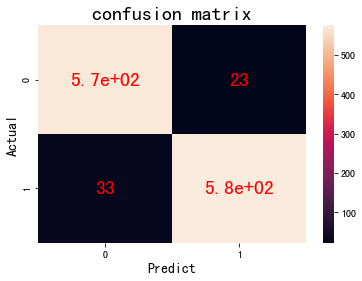

In [16]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

batch_size=4

In [17]:
valid_acc,confusion_matrix,general_index = test_loop(test_dataloader, model, mode='Test')
print(f'valid_acc:{valid_acc}')
print(f'confusion_matrix:{confusion_matrix}')
print(f'general_index:{general_index}')
print("Done!")

Test Accuracy: 96.0%

valid_acc:0.96
confusion_matrix:[[578  14]
 [ 34 574]]
general_index:{'accuracy_score': 0.96, 'precision_score': {'precision_score_micro': 0.96, 'precision_score_macro': 0.9603174603174602, 'precision_score_weighted': 0.9605291005291005, 'precision_score_None': array([0.94444444, 0.97619048])}, 'recall_score': {'recall_score_micro': 0.96, 'recall_score_macro': 0.9602151493598862, 'recall_score_weighted': 0.96, 'recall_score_None': array([0.97635135, 0.94407895])}, 'f1_score': {'f1_score_micro': 0.96, 'f1_score_macro': 0.9599995555506172, 'f1_score_weighted': 0.959997777753086, 'f1_score_None': array([0.96013289, 0.95986622])}}
Done!


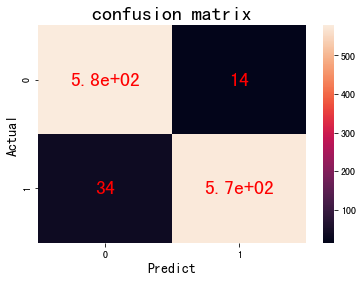

In [18]:
sns.heatmap(confusion_matrix,annot=True,annot_kws={'size':20,'weight':'bold','color':'red'})
plt.title('confusion matrix',fontsize=20)
plt.xlabel('Predict',fontsize=14)
plt.ylabel('Actual',fontsize=14)
plt.show()

# Longformer模型

In [ ]:
from torch import nn
from transformers import AutoModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
checkpoint = "bert-base-chinese"

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.bert_encoder = AutoModel.from_pretrained(checkpoint)
        self.classifier = nn.Linear(768, 2)

    def forward(self, x):
        bert_output = self.bert_encoder(**x)
        cls_vectors = bert_output.last_hidden_state[:, 0]
        logits = self.classifier(cls_vectors)
        return logits

# 先把模型的类加载一下
model = NeuralNetwork().to(device)
print(model)